# Anomaly Detection (and SVD-III)

In [1]:
%matplotlib inline
%config InlineBackend.figure_format='retina'
# import libraries
import numpy as np
import matplotlib as mp
import pandas as pd
import matplotlib.pyplot as plt
import pandas as pd
import slideUtilities as sl
import laUtilities as ut
from importlib import reload
from datetime import datetime
from IPython.display import Image
from IPython.display import display_html
from IPython.display import display
from IPython.display import Math
from IPython.display import Latex
from IPython.display import HTML
print('')

In [2]:
%%html
<style>
 .container.slides .celltoolbar, .container.slides .hide-in-slideshow {
    display: None ! important;
}
</style>

%Set up useful MathJax (Latex) macros.
%See http://docs.mathjax.org/en/latest/tex.html#defining-tex-macros
%These are for use in the slideshow
$\newcommand{\mat}[1]{\left[\begin{array}#1\end{array}\right]}$
$\newcommand{\vx}{{\mathbf x}}$
$\newcommand{\hx}{\hat{\mathbf x}}$
$\newcommand{\vbt}{{\mathbf\beta}}$
$\newcommand{\vy}{{\mathbf y}}$
$\newcommand{\vz}{{\mathbf z}}$
$\newcommand{\R}{{\mathbb{R}}}$
$\newcommand{\vu}{{\mathbf u}}$
$\newcommand{\vv}{{\mathbf v}}$
$\newcommand{\vw}{{\mathbf w}}$
$\newcommand{\col}{{\operatorname{Col}}}$
$\newcommand{\nul}{{\operatorname{Nul}}}$
$\newcommand{\vb}{{\mathbf b}}$
$\newcommand{\va}{{\mathbf a}}$
$\newcommand{\ve}{{\mathbf e}}$
$\newcommand{\setb}{{\mathcal{B}}}$
$\newcommand{\rank}{{\operatorname{rank}}}$
$\newcommand{\vp}{{\mathbf p}}$

Today we'll discuss an important topic related to unsupervised learning: __anomaly detection.__

Anomalies are objects that are different from most other objects.   

Anomalies are also called "outliers".

Furthermore, we usually expect that anomalies are different in a __qualitative__ sense as well.

> An outlier is an observation that differs so much from other observations as to arouse suspicion that it was generated by a different mechanism

-- Douglas Hawkins


Why might we be interested in anomalies?

* __Fraud Detection__ - stolen credit cards
* __Intrusion Detection__ - attacks on computer systems
* __Public Health__ - occurrence of disease in a particular area
* __Medicine__ - a set of symptoms may indicate a disease

Anomaly detection presents a number of challenges.

It is an __unsupervised__ method -- so validation is hard
* It is hard to know that your set of anomalies is correct
* It is hard to know how many anomalies there are in the data

The main assumption made in anomaly detection:

__There are many more "normal" observations than "abnormal" (anomalies) in the data.__

Methodologically, anomaly detection proceeds as follows:

1. Build a profile of "normal" data objects
    * These can be patterns, summary statistics, or more complicated models
2. Use the "normal" profile to detect anomalies
    * These are observations whose characteristics differ significantly from the normal profile.

## Approaches To Anomaly Detection

The idea that "normal behavior is what is most frequently observed" is the basis for most anomaly detection methods.

It suggests a number of approaches.

__Model-Based Methods.__

Here, we assume that a model for the data will describe most of the data.   What is not well described by the model are potentially anomalies.

1) Use the data to estimate the parameters of a probability distribution.   For example, one might estimate a normal distribution from the data.

* Then an object that is very unlikely under the model may be an anomaly.

2) Model the data as a set of clusters (cluster the data).

* Then an object that does not strongly belong to any cluster may be an anomaly.

3) Model the data using a regression.
* Then an object that is far from its predicted value may be an anomaly.

__Other Methods.__

If you cannot build a model of the data, you can still:

1. Define an anomaly as one that is distant from all (or most) other objects.
2. Define an anomaly as one that is in an unusually-low-density region.

## Model-Based Detection: 1-D Gaussian

To start, we will examine a very simple case: anomaly detection in 1-D.

(-4.5, 4.5)

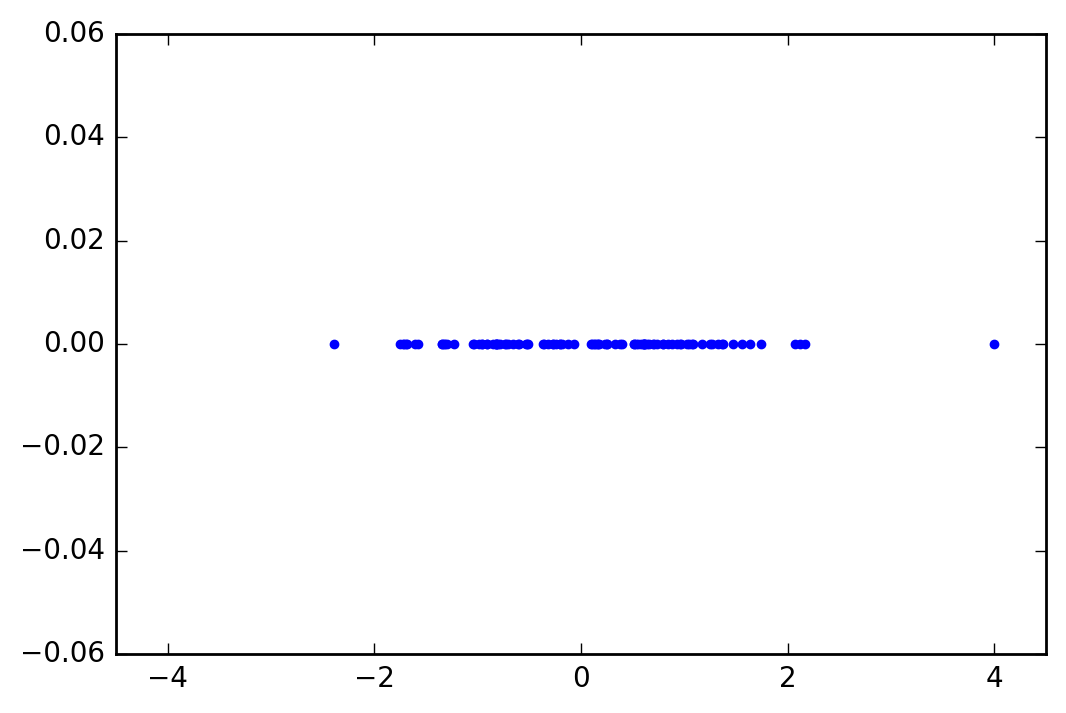

In [16]:
n_samples = 100
data = np.random.randn(n_samples, 1)
data = np.concatenate([data, np.array([[4]])])
plt.plot(data, np.zeros(n_samples+1), '.')
plt.xlim([-4.5, 4.5])

In [19]:
m_est = np.mean(data)
std_est = np.std(data)

In [28]:
import scipy.stats
norm = scipy.stats.distributions.norm(m_est,std_est)

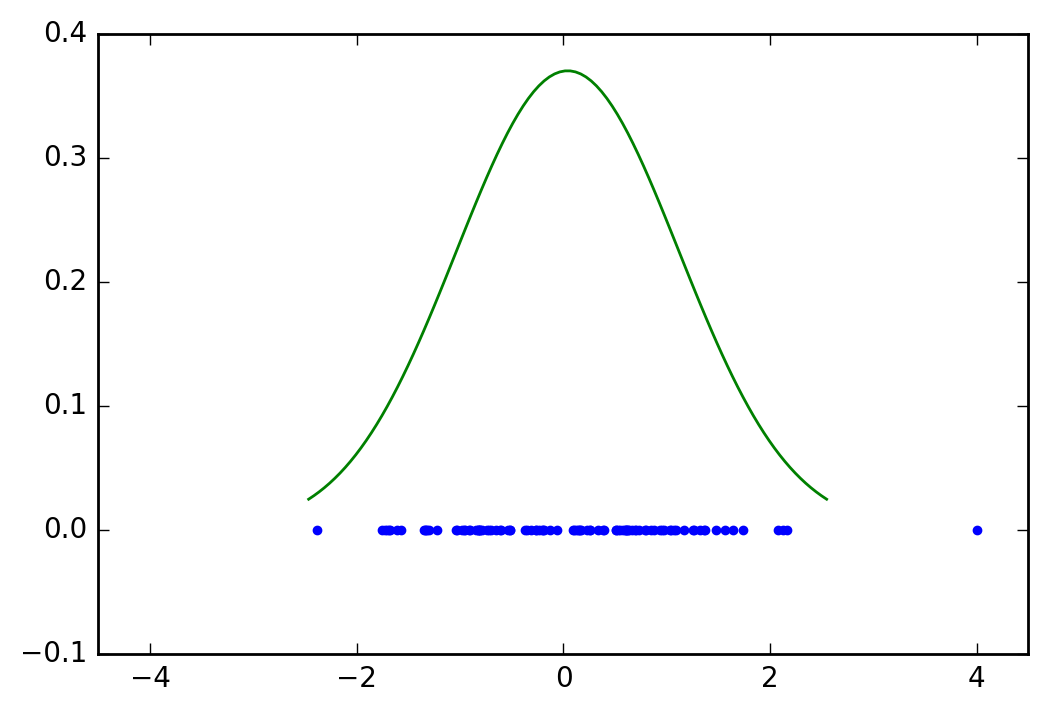

In [32]:
plt.plot(data, np.zeros(n_samples+1), '.')
plt.xlim([-4.5, 4.5])
plt.ylim([-0.1,0.4])
x = np.linspace(norm.ppf(0.01),
                 norm.ppf(0.99), 100)
plt.plot(x, norm.pdf(x), '-')

Let's calculate the probability of each data point under this model.

In [34]:
prob_data = [norm.pdf(x) for x in data]
prob_data

[array([ 0.2354293]),
 array([ 0.26317353]),
 array([ 0.30049374]),
 array([ 0.36314494]),
 array([ 0.25497033]),
 array([ 0.35790232]),
 array([ 0.36461044]),
 array([ 0.308001]),
 array([ 0.32396243]),
 array([ 0.36984658]),
 array([ 0.3367058]),
 array([ 0.28063651]),
 array([ 0.11495059]),
 array([ 0.35518286]),
 array([ 0.369664]),
 array([ 0.21394905]),
 array([ 0.32039608]),
 array([ 0.36849472]),
 array([ 0.36923985]),
 array([ 0.15292264]),
 array([ 0.30122444]),
 array([ 0.36228104]),
 array([ 0.22553129]),
 array([ 0.19705777]),
 array([ 0.32348669]),
 array([ 0.36057385]),
 array([ 0.25020023]),
 array([ 0.09273043]),
 array([ 0.28979294]),
 array([ 0.3096564]),
 array([ 0.25126301]),
 array([ 0.26868257]),
 array([ 0.16756643]),
 array([ 0.26919347]),
 array([ 0.32080299]),
 array([ 0.23414161]),
 array([ 0.27427519]),
 array([ 0.25799806]),
 array([ 0.10200708]),
 array([ 0.35054451]),
 array([ 0.36819663]),
 array([ 0.05742447]),
 array([ 0.32273507]),
 array([ 0.0291779

To make this easier to analyze, let's work with the (negative) log probability of the data:

(-4.5, 4.5)

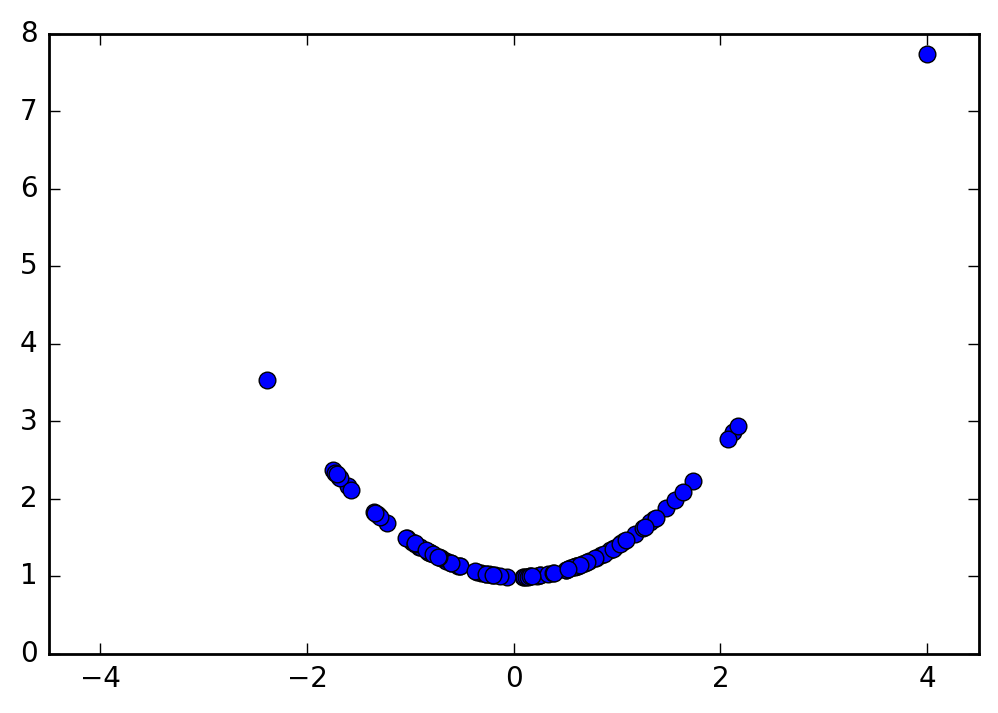

In [38]:
import math
log_prob_data = [-math.log(x) for x in prob_data]
plt.plot(data, log_prob_data, 'o')
plt.xlim([-4.5,4.5])

This plot makes clear that there is one point that is **very** unlikely under our model.  We would be justified in identifying this as an anomaly.

In particular, the probability of the extreme point under this model is 0.00043222.   

We would not expect to see a sample with this probability unless we sampled the distribution 1/0.0004322 = 2314 times. 

However we have only 101 data points.

__An important point.__

Notice that we estimated the mean and standard deviation of our model using __all__ the data -- including the point that we later decided was an anomaly.

Of course the correct parameter estimation should __not__ have included the anomalous data point, if it truly "was generated by a different mechanism."

On one hand, our estimation approach gives us an approximation to the true distribution. 

This approximation may be justified under the assumption that "most of the data points are not anomalies".

And since we don't know the anomalies in advance (of course) we cannot simply remove them before we estimate the parameters.

There are more sophisticated approaches to try to address this problem -- we won't discuss them, but you should be aware that it is possible to do better than what we did here.

## Extending to multiple dimensions

For data with multiple features we would like to take the same approach. 

We would like to identify points as outliers if they have low probability under a __multivariate__ Gaussian model.

In [167]:
n_samples = 1000
cov = np.array([[1., 0.75],[0.75, 3]])
mean = np.array([0.,0])
apt1 = np.array([2,8])
apt2 = np.array([-4,4])
data = np.random.multivariate_normal(mean, cov, n_samples)
data = np.concatenate([data,np.array([apt1,apt2])])

(-10, 10)

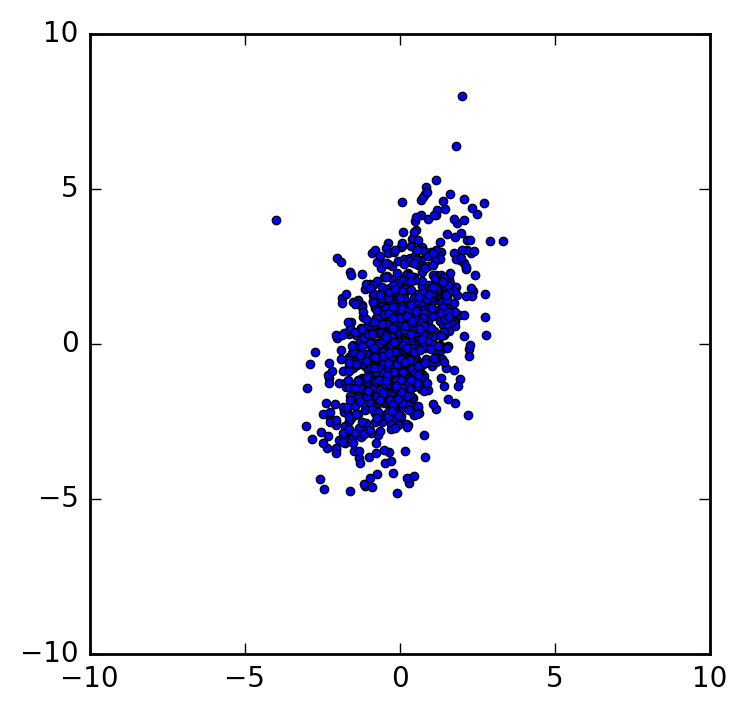

In [168]:
plt.plot(data[:,0],data[:,1],'o',markersize=3)
plt.axis('square')
plt.xlim([-10,10])
plt.ylim([-10,10])

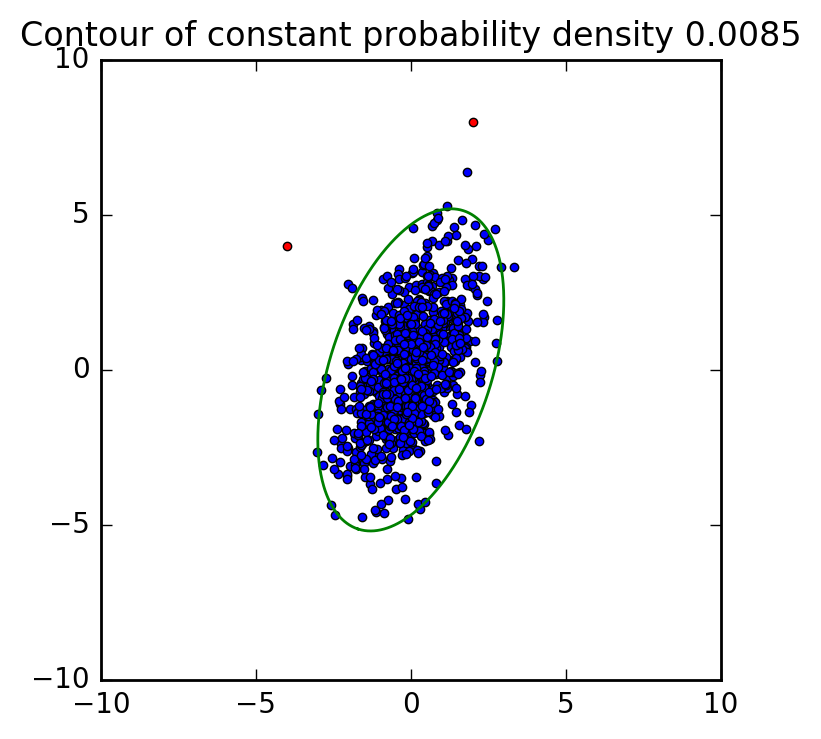

In [169]:
theta = np.linspace(0,2*math.pi,500)
coords = np.array([np.sin(theta), np.cos(theta)])
cov = np.array([[1., 0.75],[0.75, 3]])
lam, evec = np.linalg.eig(cov)
c = evec @ np.diag(np.sqrt(lam))
coords = 3 * c @ coords
plt.plot(data[:-2,0],data[:-2,1],'o',markersize=3,color='b')
plt.plot(data[-2:,0],data[-2:,1],'o',markersize=3,color='r')
plt.plot(coords[0], coords[1], '-', color='g')
plt.axis('square')
plt.xlim([-10,10])
plt.ylim([-10,10])
plt.title(r'Contour of constant probability density {:0.4f}'.format(norm.pdf(3)))

Consider the following candidates for outliers: (2,8) and (-4,4).

These are marked in red.

In [174]:
print('{} is {:0.3f} from the cluster center.'.format(apt1,np.linalg.norm(apt1)))
print('{} is {:0.3f} from the cluster center.'.format(apt2,np.linalg.norm(apt2)))

[2 8] is 8.246 from the cluster center.
[-4  4] is 5.657 from the cluster center.


Which one is more of an outlier?

We have to take into account the __probability__ of the point under the (presumed) multivariate Gaussian distribution.

Using standard (MLE) methods (on all the data), we estimate the Gaussian distribution to have mean 

$$ \mu = \mat{{c}0\\0}$$

and covariance

$$\Sigma = \mat{{cc}1&0.75\\0.75&3}$$

A convenient way to express the probability is via its negative log:

$$ - \log(P[\vx]) - C = (\vx - \mu)^T \Sigma^{-1} (\vx - \mu)$$

($C$ is a constant that does not depend on $\vx$.)

The expression on the right is called the __Mahalanobis distance.__  

It is essentially the distance to the center of the Gaussian, scaled to take into account the __shape__ of the Gaussian.

In [184]:
p = np.array([apt1]).T
mp = p.T @ np.linalg.inv(cov) @ p
print('{} has Mahalanobis distance {:0.3f}.'.format(apt1,mp[0,0]))
p = np.array([apt2]).T
mp = p.T @ np.linalg.inv(cov) @ p
print('{} has Mahalanobis distance {:0.3f}.'.format(apt2,mp[0,0]))

[2 8] has Mahalanobis distance 21.333.
[-4  4] has Mahalanobis distance 36.103.


## High Dimensional Data

When our data objects have hundreds (or millions) of features, we can no longer build a distributional model.   

For a dataset with 1,000 features, we need to build a 1,000 $\times$ 1,000 covariance matrix -- which has a million elements.

We have a problem of high dimensionality -- and a natural approach is to consider dimensionality reduction.

SVD to the rescue again!

As we've seen, dimensionality reduction will work if the dataset shows low effective rank.

Let's consider how we might do anomaly detection when data has low effective rank.

Since 
* the principle of anomaly detection is that most objects are normal, and  
* the data has low effective rank, 

one way to look for anomalies is to find objects that are __not__ well described by the low rank model.



In [239]:
n_samples = 500
# Create correlated multivariate Gaussian samples
C = np.array([[0.1, 0.6], [2., .6]])
np.random.seed(1)
X = np.random.randn(n_samples, 2) @ C + np.array([-6, 3])
# Mean center
Xc = X - np.mean(X,axis=0)
# Create an anomalous data point
apt = np.array([5,5])
Xc = np.concatenate([Xc, np.array([apt])],axis=0)
# SVD of all data
u, s, vt = np.linalg.svd(Xc,full_matrices=False)
orthog_dir = np.array([-vt[0,1], vt[0,0]])
# project points onto subspace
scopy = s.copy()
scopy[1] = 0.
reducedX = u @ np.diag(scopy) @ vt
apt_proj = reducedX[-1,:]

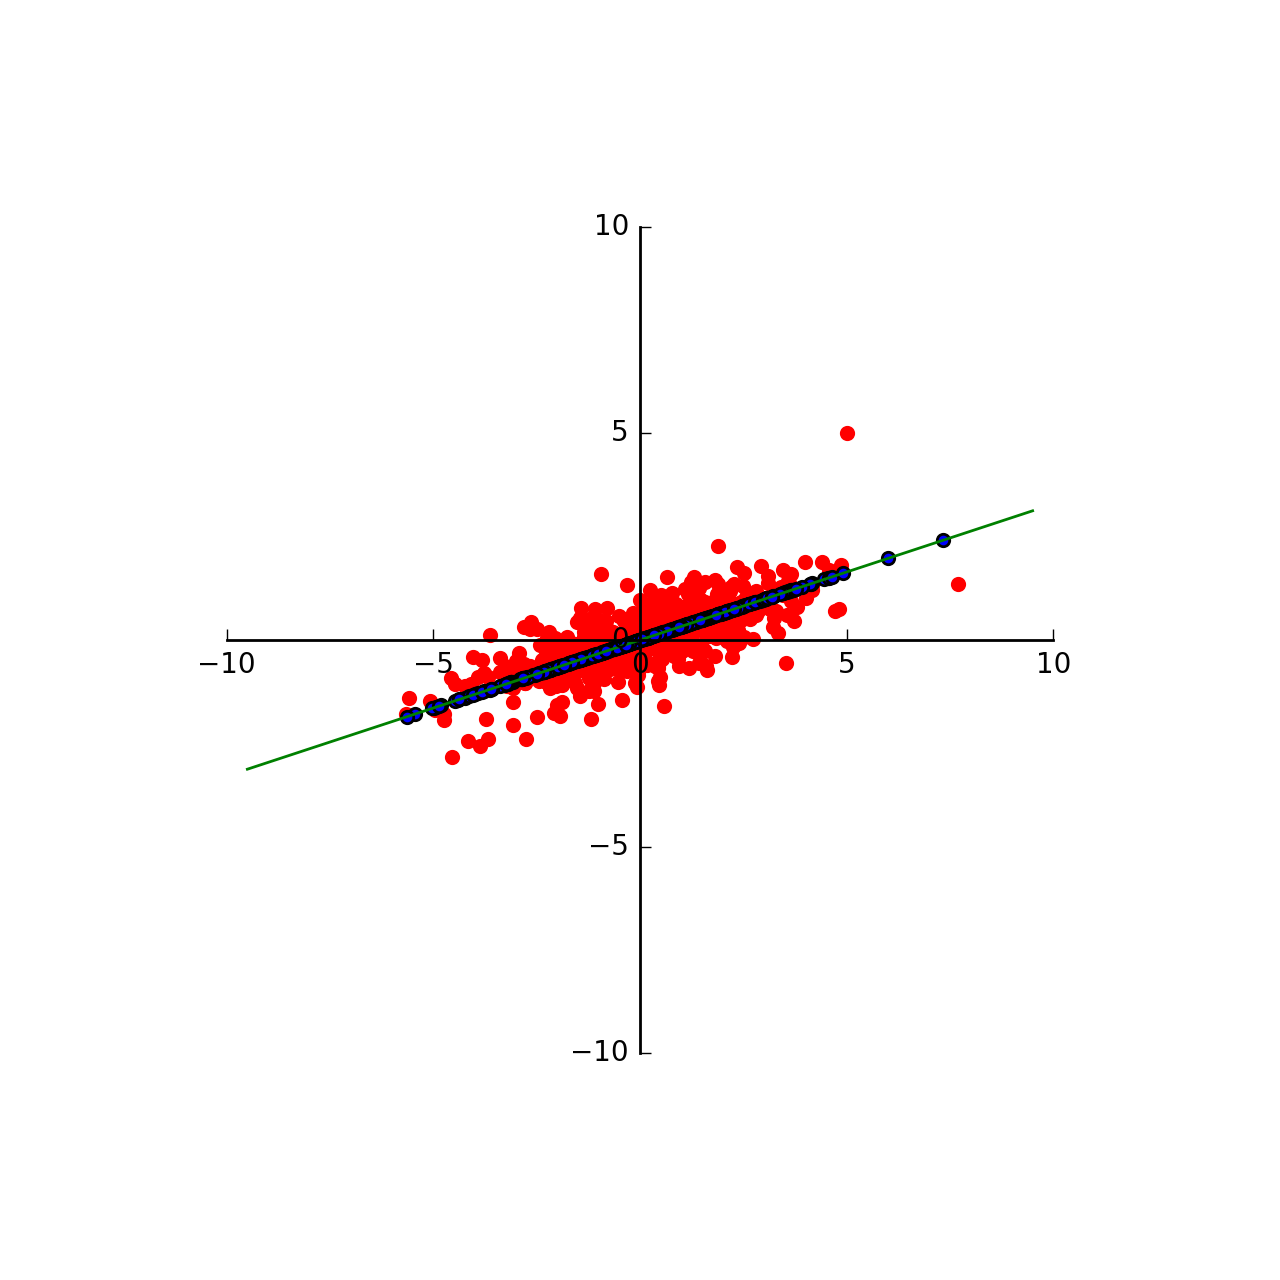

In [253]:
# plot
ax = ut.plotSetup(-10,10,-10,10,(8,8))
ut.centerAxes(ax)
plt.axis('equal')
plt.scatter(Xc[:,0],Xc[:,1], color='r')
plt.scatter(reducedX[:,0], reducedX[:,1])
endpoints = np.array([[-10],[10]]) @ vt[[0],:]
_ = plt.plot(endpoints[:,0], endpoints[:,1], 'g-')

Is there a point here that is not well described by the low-rank (rank-1) model?

How would we quantify this fact?

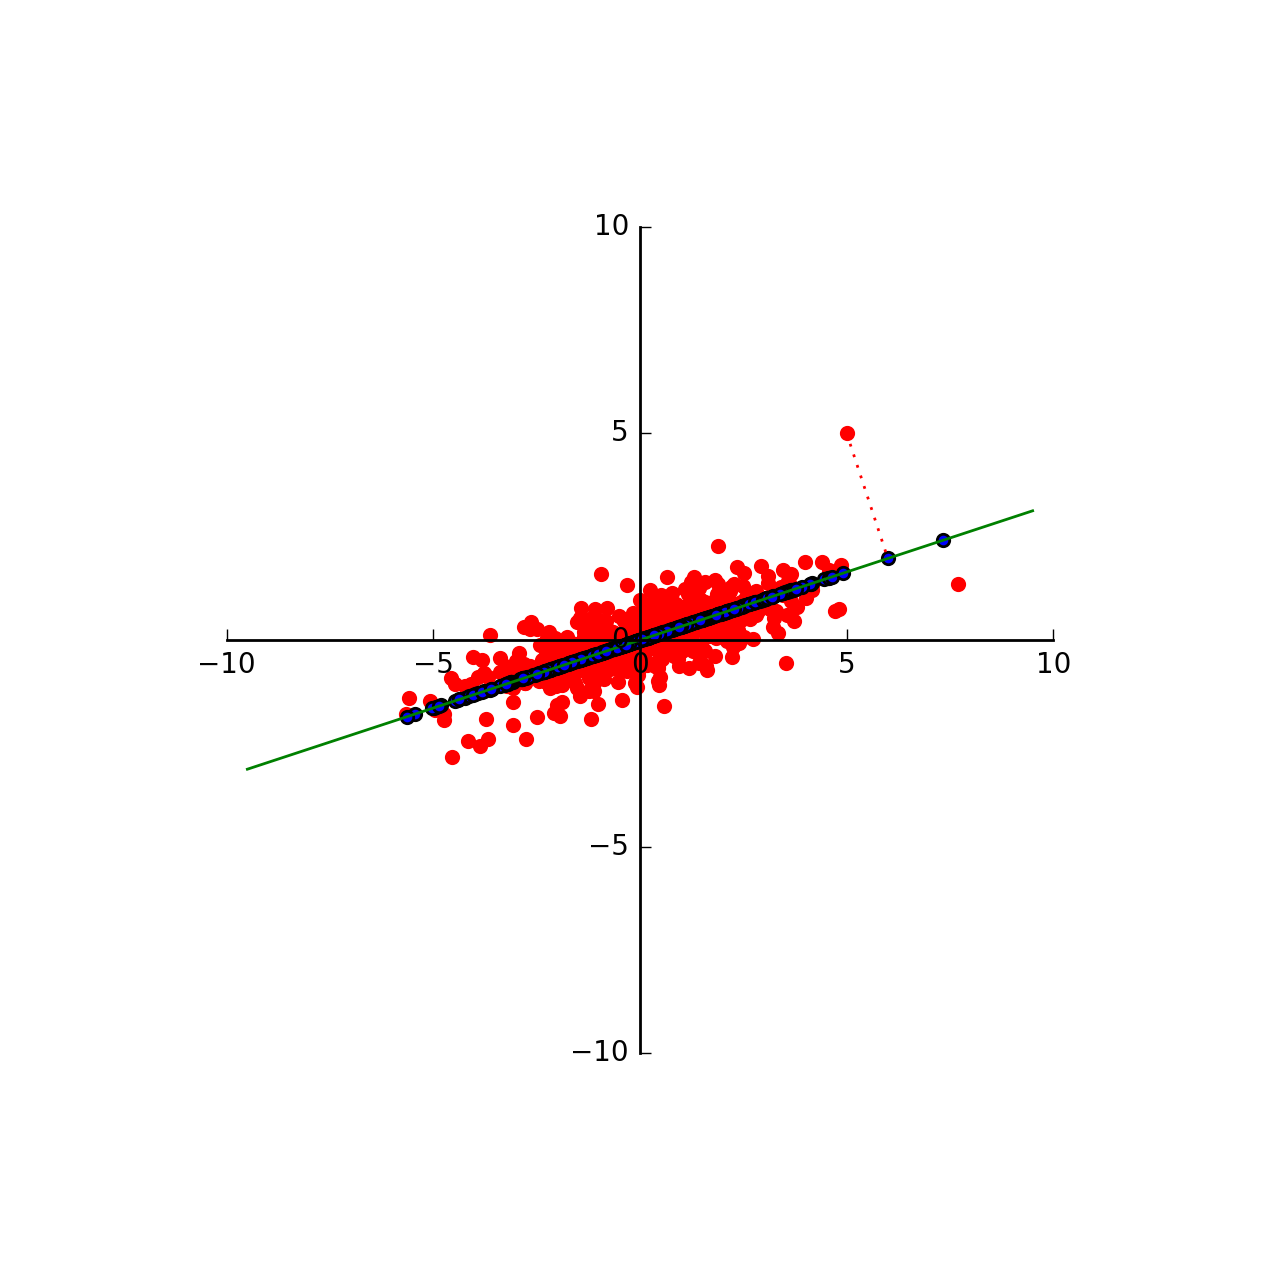

In [254]:
# plot
ax = ut.plotSetup(-10,10,-10,10,(8,8))
ut.centerAxes(ax)
plt.axis('equal')
plt.scatter(Xc[:,0],Xc[:,1], color='r')
plt.scatter(reducedX[:,0], reducedX[:,1])
plt.plot([apt[0],apt_proj[0]],[apt[1],apt_proj[1]],'r:')
endpoints = np.array([[-10],[10]]) @ vt[[0],:]
_ = plt.plot(endpoints[:,0], endpoints[:,1], 'g-')

What is the distance of the anomalous point from the subspace?

It is simply the **length of the difference** between the point and its projection in the subspace.

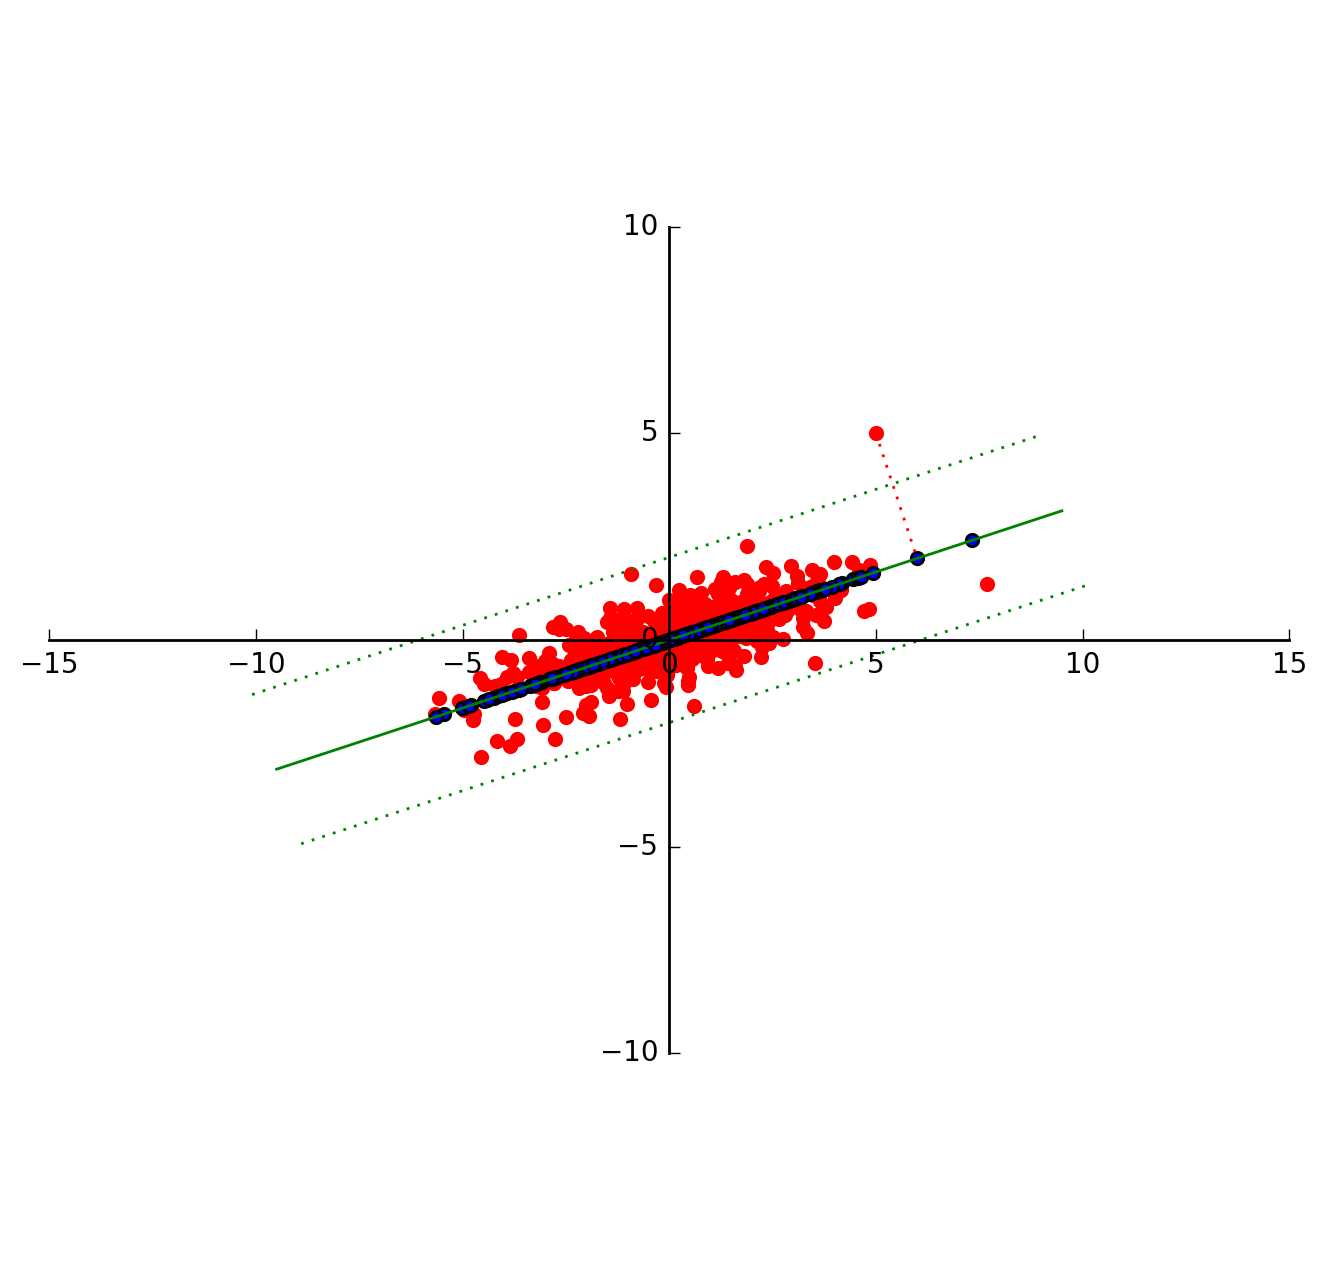

In [255]:
# plot
ax = ut.plotSetup(-10,10,-10,10,(8,8))
ut.centerAxes(ax)
plt.axis('equal')
plt.scatter(Xc[:,0],Xc[:,1], color='r')
plt.scatter(reducedX[:,0], reducedX[:,1])
plt.plot([apt[0],apt_proj[0]],[apt[1],apt_proj[1]],'r:')
endpoints = np.array([[-10],[10]]) @ vt[[0],:]
alpha = 1.9
plt.plot(alpha*orthog_dir[0]+endpoints[:,0], alpha*orthog_dir[1]+endpoints[:,1], 'g:')
plt.plot(endpoints[:,0]-alpha*orthog_dir[0], endpoints[:,1]-alpha*orthog_dir[1], 'g:')
_ = plt.plot(endpoints[:,0], endpoints[:,1], 'g-')

So to do anomaly detection via the __subspace__ method, we set a threshold on the distance of each point from the subspace.

## Anomaly Detection via the Low-Dimensional Phenomenon

In practice, this is a simple process.

Given a data matrix $A$:

1.  Compute the Singular value decomposition of $A$, $$U\Sigma V^T = A.$$
2.  Compute a low-rank approximation to $A$, $$N = U'\Sigma'(V')^T.$$
3.  Compute the residuls not explained by $N$:  $$O = A-N.$$
4.  Indentify the rows of $O$ with largest $\ell_2$ norm: these rows correspond to anomalies.

In this recipe, rows of $O$ are the difference vectors between each point and its projection in the subspace.

So the $\ell_2$ norm gives us the distance of each point from the subspace.

There are two unspecified steps in the process:

1. Selecting the columns of $U$ to be used in forming $N$
2. Deciding how many of the largest rows of $O$ are anomalies.

For 1, the general idea is to choose a $k$ at the knee of the singular value plot.  
For 2, there are statistical methods that generally work reasonably well.

### Example 1: Facebook Spatial Likes

This data consists of the number of 'Likes' during a six month period, for each of 9000 users across the 210 content categories that Facebook assigns to pages.

Rows are users, Columns are categories.  $A$ is $9000 \times 210$.

$$ \mbox{users}\left\{\begin{array}{c}\;\\\;\\\;\\\;\\\;\end{array}\right.\;\;\overbrace{\left[\begin{array}{cccc}\begin{array}{c}\vdots\\\vdots\\{\bf a_1}\\\vdots\\\vdots\end{array}&\begin{array}{c}\vdots\\\vdots\\{\bf a_2}\\\vdots\\\vdots\end{array}&\dots&\begin{array}{c}\vdots\\\vdots\\{\bf a_n}\\\vdots\\\vdots\end{array}\\\end{array}\right]}^{\mbox{FB categories}} =
\overbrace{\left[\begin{array}{cc}\vdots&\vdots\\\vdots&\vdots\\\sigma_1\vu_1&\sigma_k\vu_k\\\vdots&\vdots\\\vdots&\vdots\end{array}\right]}^{\large k}
\times
\left[\begin{array}{ccccc}\dots&\dots&\vv_1&\dots&\dots\\\dots&\dots&\vv_k&\dots&\dots\end{array}\right]$$


$$ A = U\Sigma V^T$$

First we'll look at the total number of likes for each user (the row sums).

In [191]:
data = np.loadtxt('data/social/data/spatial_data.txt')
FBSpatial = data[:,1:]
FBSnorm = np.linalg.norm(FBSpatial,axis=1,ord=1)
plt.plot(FBSnorm)
plt.title('Number of Likes Per User')
plt.xlabel('Users')

FileNotFoundError: [Errno 2] No such file or directory: 'data/social/data/spatial_data.txt'

Now let's check whether the low dimensional phenomenon holds.

In [ ]:
u,s,vt = np.linalg.svd(FBSpatial,full_matrices=False)
plt.plot(s/np.linalg.norm(FBSpatial))
plt.title('Singular Values of Spatial Like Matrix')

Now let's 

1. Separate the portion of the data lying in the normal space from the amonalous space,
2. Identify the top 30 anomalous users (having the largest anomalous component), and
3. Plot their total number of likes against the set of all users.

In [ ]:
unorm = u[:,0:25]
P = unorm.dot(unorm.T)
N = P.dot(FBSpatial)
O = FBSpatial - N
Onorm = np.linalg.norm(O,axis=1)
# large = np.nonzero(Onorm>100))
# get top 30 anomalies
anomSet = np.argsort(Onorm)[-30:]
plt.plot(FBSnorm)
plt.plot(anomSet,FBSnorm[anomSet],'ro')
plt.title('Top 30 Anomalous Users')

Next we'll pick out nine anomalous users and look at their pattern of likes across the 210 categories.

In [ ]:
plt.figure(figsize=(9,6))
for i in range(1,10):
    ax = plt.subplot(3,3,i)
    plt.plot(FBSpatial[anomSet[i-1],:])
    plt.xlabel('FB Content Categories')
plt.subplots_adjust(wspace=0.25,hspace=0.45)
plt.suptitle('Nine Example Anomalous Users',size=20)

And let's do the same for nine normal users.

In [ ]:
# choose non-anomalous users
set = np.argsort(Onorm)[0:7000]
# that have high overall volume
max = np.argsort(FBSnorm[set])[::-1]
plt.figure(figsize=(9,6))
for i in range(1,10):
    ax = plt.subplot(3,3,i)
    plt.plot(FBSpatial[set[max[i-1]],:])
    plt.xlabel('FB Content Categories')
plt.subplots_adjust(wspace=0.25,hspace=0.45)
plt.suptitle('Nine Example Normal Users',size=20)

### Example 2: Facebook Temporal LIkes

This data consists of the number of 'Likes' for each of 9000 users, over 6 months, on a daily basis

Rows are users, Columns are days.

First we'll look at the singular values.

In [ ]:
data = np.loadtxt('data/social/data/temporal_data.txt')
FBTemporal = data[:,1:]
FBTnorm = np.linalg.norm(FBTemporal,axis=1,ord=1)
u,s,vt = np.linalg.svd(FBTemporal,full_matrices=False)
plt.plot(s/np.linalg.norm(FBTemporal))

Next, plot the anomalous users as before.

In [ ]:
# choose the top 25 columns of U for the normal space
unorm = u[:,0:24]
P = unorm.dot(unorm.T)
N = P.dot(FBTemporal)
O = FBTemporal - N
Onorm = np.linalg.norm(O,axis=1)
# get top 30 anomalies
anomSet = np.argsort(Onorm)[-30:]
plt.plot(FBTnorm)
plt.plot(anomSet,FBTnorm[anomSet],'ro')

Now let's look at sample anomalous and normal users.   

In [ ]:
plt.figure(figsize=(9,6))
for i in range(1,10):
    ax = plt.subplot(3,3,i)
    plt.plot(FBTemporal[anomSet[i-1],:])
    plt.xlabel('Days')
plt.subplots_adjust(wspace=0.25,hspace=0.45)
plt.suptitle('Nine Example Anomalous Users',size=20)

In [ ]:
# choose non-anomalous users
set = np.argsort(Onorm)[0:7000]
# that have high overall volume
max = np.argsort(FBTnorm[set])[::-1]
plt.figure(figsize=(9,6))
for i in range(1,10):
    ax = plt.subplot(3,3,i)
    plt.plot(FBTemporal[set[max[i-1]],:])
    plt.xlabel('Days')
plt.subplots_adjust(wspace=0.25,hspace=0.45)
plt.suptitle('Nine Example Normal Users',size=20)

Interestingly, what makes a user anomalous seems to have reversed from the case of the spatial data.